# Предсказание следующей покупки в течении следующих 30 дней.

<img src="https://marketoonist.com/wp-content/uploads/2024/02/240212.n.search.jpg" width="500" align="right"/> Удержание клиентов имеет решающее значение для успеха на жестоком рынке. Удержание текущих потребителей более рентабельно, чем приобретение новых.

Удержание клиентов приводит к появлению преданной клиентуры, увеличению доходов и долгосрочной прибыльности. Однако ряд факторов, в том числе экономические условия, конкуренция и тенденции моды, затрудняют прогнозирование поведения и предпочтений клиентов. 

Предприятиям необходимы сложные возможности машинного обучения и анализа данных для анализа потребительских данных и составления точных прогнозов для решения этих проблем. 

Предприятия могут корректировать маркетинговые усилия, улучшать качество обслуживания клиентов и повышать уровень счастья, предвидя следующие покупки своих потребителей, что в конечном итоге повысит их удержание и лояльность.

## Настройка проекта.

### Импорт библиотек, модулей, классов и функций.

In [1]:
import os
from pathlib import Path
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

### Настройка окружения и глобальные переменные.

In [2]:
RANDOM_STATE = 42

In [3]:
plt.style.use('default')

### Пользовательские функции.

In [4]:
def my_analyze_classification_performance(model=None, dummy=None, target=None, features=None):
    '''
    Функция предназначена для анализа производительности моделей классификации,
    включая построение ROC-кривой и кривой точности и полноты.
    Она также поддерживает сравнение с dummy моделью, если она предоставлена.
    '''
        
    # Получаем имя модели (закомментированная строка с оригинальной версии кода)
    model_name = 'CatBoostClassifier'  #model.__class__.__name

    # Вычисляем вероятности прогнозов целевой переменной
    target_train_pred_prob = model.predict_proba(features)[:, 1]
    
    # Вычисляем ROC-кривую и AUC-ROC
    fpr, tpr, thresholds = roc_curve(target, target_train_pred_prob)
    auc_roc = roc_auc_score(target, target_train_pred_prob)

    # Если есть dummy модель, то вычисляем ее вероятности и метрики ROC и AUC
    if dummy is not None:
        target_train_pred_prob_dummy = dummy.predict_proba(features)[:, 1]
        fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(target, target_train_pred_prob_dummy)
        auc_roc_dummy = roc_auc_score(target, target_train_pred_prob_dummy)

    # Создаем график с двумя подграфиками
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f'Производительность модели классификации {model_name}')

    # График ROC-кривой
    ax[0].plot(fpr, tpr, color='SteelBlue', label='ROC Curve')
    if dummy is not None:
        ax[0].plot(fpr_dummy, tpr_dummy, '--', color='DarkRed', label=('Dummy ' + dummy.strategy))
    else:
        ax[0].plot([0, 1], [0, 1], '--', color='DarkRed', label='Random Guess')
    ax[0].legend(loc='lower right')
    if dummy is not None:
        ax[0].set_title(f'ROC curve (AUC = {auc_roc:.3f})\nDummy {dummy.strategy} AUC = {auc_roc_dummy:.3f}')
    else:
        ax[0].set_title(f'ROC curve (AUC = {auc_roc:.3f})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].grid(True)

    # График кривой точности и полноты
    precision, recall, thresholds = precision_recall_curve(target, target_train_pred_prob)
    auc_pr = average_precision_score(target, target_train_pred_prob)

    # Если есть dummy модель, то вычисляем ее кривую точности и полноты, а также AUC
    if dummy is not None:
        precision_dummy, recall_dummy, thresholds_dummy = precision_recall_curve(target, target_train_pred_prob_dummy)
        auc_pr_dummy = average_precision_score(target, target_train_pred_prob_dummy)

    ax[1].plot(recall, precision, color='SteelBlue', label='Precision-Recall Curve')
    if dummy is not None:
        ax[1].plot(recall_dummy, precision_dummy, '--', color='DarkRed', label=('Dummy ' + dummy.strategy))
    else:
        ax[1].plot([0, 1], [1, 0], '--', color='DarkRed', label='Random Guess')
    ax[1].legend(loc='lower left')
    if dummy is not None:
        ax[1].set_title(f'Precision-Recall curve (AUC = {auc_pr:.3f})\nDummy {dummy.strategy} AUC = {auc_pr_dummy:.3f}')
    else:
        ax[1].set_title(f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].grid(True)

    # Отображаем графики
    plt.tight_layout()
    plt.show()

## Загрузка данных.

In [5]:
apparel_purchases = pd.read_csv(
    r'data\apparel-purchases.csv',
    parse_dates=['date', 'date'],
    dtype={'client_id': 'object'},
)

### Анализ.

In [6]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  object        
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 6.1+ MB


In [7]:
apparel_purchases.head()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [8]:
apparel_purchases.describe(include='all')

,client_id,quantity,price,date,message_id,recommended_by
count,133104,133104.000000,133104.000000,133104,133104,133104
unique,28891,NaN,NaN,NaN,25426,1
top,1515915625853312319,NaN,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,bulk_message
freq,275,NaN,NaN,NaN,271,133104
mean,NaN,1.004312,1110.433067,2023-04-04 04:27:23.562928128,NaN,NaN
min,NaN,1.000000,1.000000,2022-10-26 00:00:00,NaN,NaN
25%,NaN,1.000000,280.000000,2022-12-22 00:00:00,NaN,NaN
50%,NaN,1.000000,799.000000,2023-04-19 00:00:00,NaN,NaN
75%,NaN,1.000000,1499.000000,2023-06-16 00:00:00,NaN,NaN
max,NaN,30.000000,63499.000000,2023-10-26 00:00:00,NaN,NaN


### Удаление неинформативтивных признаков.

In [9]:
apparel_purchases.drop(['message_id', 'recommended_by'], axis=1, inplace=True)

### Сортировка данных.

In [10]:
apparel_purchases = apparel_purchases.sort_values(
    by=['date', 'client_id']
).reset_index(drop=True)

In [11]:
apparel_purchases.head()

,client_id,quantity,price,date
0,1515915625468222486,1,3999.0,2022-10-26
1,1515915625468222486,1,3999.0,2022-10-26
2,1515915625489888679,1,7.0,2022-10-26
3,1515915625489888679,1,7.0,2022-10-26
4,1515915625489888679,1,2199.0,2022-10-26


## Простая генерация фичей и таргета.

### Простое сумирование по дню и клиенту.

In [12]:
per_client_purchases = apparel_purchases.groupby(
    ['client_id', 'date']
).agg({'price': 'sum'}).reset_index()

### Созание целевого признака в виде последних 30 дней.

Выделяем последний месяц.

In [13]:
last_30th = per_client_purchases['date'].max() - timedelta(days=30)

In [14]:
purchases_test = per_client_purchases[per_client_purchases['date'] < last_30th]
purchases_holdout = per_client_purchases[per_client_purchases['date'] >= last_30th]

In [15]:
purchase_true = purchases_holdout['client_id'].unique()

### Генерация дополнительных признаков.

Будем генерировать самые простые из возможных признаков.

In [16]:
feature_matrix = purchases_test.groupby(
    'client_id'
).agg({'date': 'max', 'price': ['sum', 'count']}).reset_index()

In [17]:
feature_matrix.head()

client_id       date    price      
                              max      sum count
0  1515915625468061003 2023-01-04  16235.0     1
1  1515915625468061170 2023-06-17  33601.0     3
2  1515915625468061994 2022-12-14   1012.0     2
3  1515915625468062158 2023-04-28   1398.0     1
4  1515915625468062184 2023-07-04   3218.0     1

Для удобства приведём названия фичей к плоскому виду.

In [18]:
feature_matrix.columns = ['client_id', 'max_date', 'sum_total', 'count']

In [19]:
feature_matrix.head()

,client_id,max_date,sum_total,count
0,1515915625468061003,2023-01-04,16235.0,1
1,1515915625468061170,2023-06-17,33601.0,3
2,1515915625468061994,2022-12-14,1012.0,2
3,1515915625468062158,2023-04-28,1398.0,1
4,1515915625468062184,2023-07-04,3218.0,1


In [20]:
feature_matrix['target'] = feature_matrix['client_id'].isin(purchase_true).astype(int)

In [21]:
feature_matrix.head()

,client_id,max_date,sum_total,count,target
0,1515915625468061003,2023-01-04,16235.0,1,0
1,1515915625468061170,2023-06-17,33601.0,3,0
2,1515915625468061994,2022-12-14,1012.0,2,0
3,1515915625468062158,2023-04-28,1398.0,1,0
4,1515915625468062184,2023-07-04,3218.0,1,0


In [22]:
feature_matrix['diff'] = (feature_matrix['max_date'].max() - feature_matrix['max_date']).dt.days

In [23]:
feature_matrix.head()

,client_id,max_date,sum_total,count,target,diff
0,1515915625468061003,2023-01-04,16235.0,1,0,264
1,1515915625468061170,2023-06-17,33601.0,3,0,100
2,1515915625468061994,2022-12-14,1012.0,2,0,285
3,1515915625468062158,2023-04-28,1398.0,1,0,150
4,1515915625468062184,2023-07-04,3218.0,1,0,83


## Обучение и тестирование модели.

### Подготовка обучающего набора данных.

In [24]:
X = feature_matrix.drop(['client_id', 'max_date', 'target'], axis=1)
y = feature_matrix['target']

### Баланс классов.

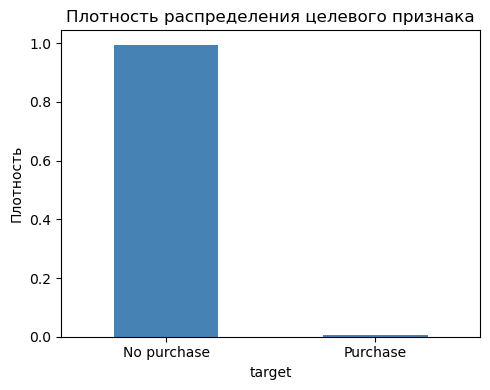

In [25]:
plt.figure(figsize=(5, 4))
y.value_counts(normalize=True).plot.bar(color='SteelBlue')
plt.ylabel('Плотность')
plt.title('Плотность распределения целевого признака')
plt.xticks([0, 1], ['No purchase', 'Purchase'], rotation=0)
plt.tight_layout()
plt.show()

### Кросс-валидация.

In [26]:
cross_validate(
    CatBoostClassifier(logging_level='Silent', random_state=RANDOM_STATE),
    X, y,
    n_jobs=-1,
    scoring=['roc_auc', 'recall', 'f1']
)

{'fit_time': array([26.71152329, 26.62674832, 26.91298389, 26.85613513,  9.86979198]),
 'score_time': array([0.0648253 , 0.06483054, 0.04488182, 0.0438838 , 0.0219419 ]),
 'test_roc_auc': array([0.66251781, 0.55529102, 0.73875657, 0.70971962, 0.66422813]),
 'test_recall': array([0., 0., 0., 0., 0.]),
 'test_f1': array([0., 0., 0., 0., 0.])}

### Feature importance.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [28]:
catboost_model = CatBoostClassifier(logging_level='Silent', random_state=RANDOM_STATE)

In [29]:
catboost_model.fit(X_train, y_train)

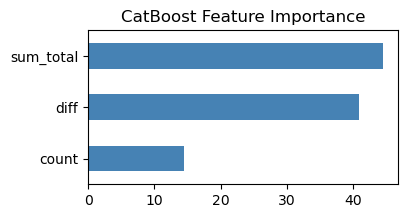

In [30]:
plt.figure(figsize=(4, 2))

pd.Series(
    index=catboost_model.feature_names_,
    data=catboost_model.feature_importances_
).sort_values().plot(kind='barh', color='SteelBlue')

plt.title('CatBoost Feature Importance')
plt.show()

### Производительность модели.

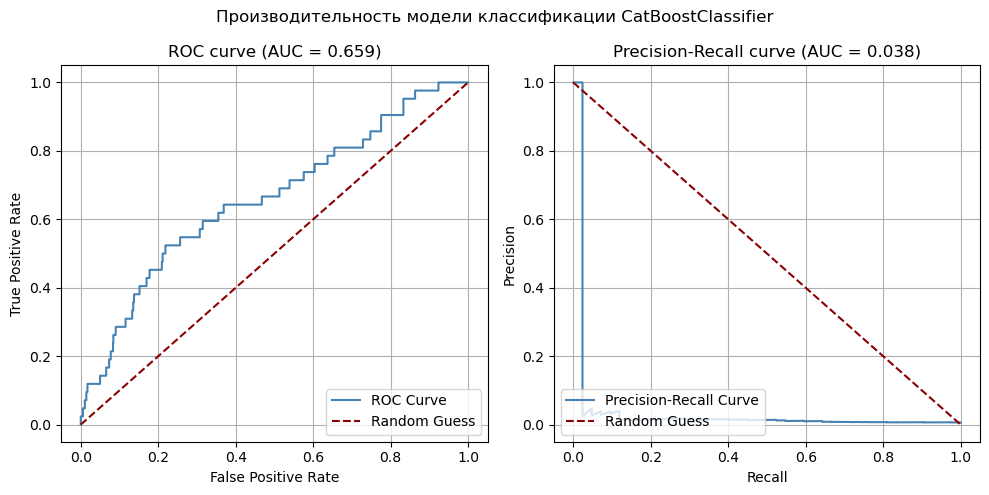

In [31]:
my_analyze_classification_performance(model=catboost_model, target=y_test, features=X_test)

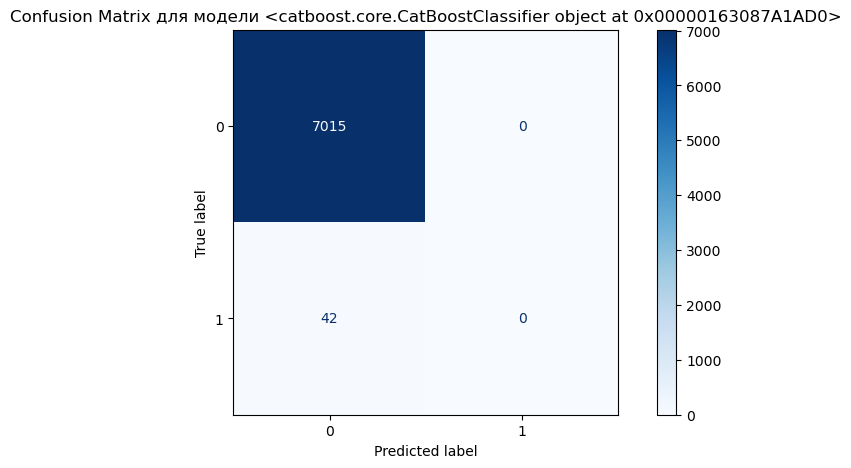

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    catboost_model.predict(X_test),
    cmap='Blues',
    ax=ax
)

ax.set_title(f'Confusion Matrix для модели {catboost_model}')
plt.show()